# Computational Methods in Simulation (CMIS) Week 5
This notebook is intended to help students make their hand-in in this week of CMIS.

Hand-ins must be submitted as a maximum 5 page pdf file in Absalon and must be made using the ACM TOG overleaf latex template

https://www.overleaf.com/latex/templates/association-for-computing-machinery-acm-large-2-column-format-template/qwcgpbmkkvpq

Notebooks must be uploaded as well so teachers have code solutions accessible if needed.

This week is based on Slides 19 - follow the detailed steps below to learn about the finite element method:

* Make an implementation of the 2D elastic assembly process
* Discuss from a computer science viewpoint which steps are the same and which steps that are different in the 2D elastic case compared to the 2D and 1D Poisson problems done in week 4.
* Speculate how to write a general FEM computer program that could simulate any partial differential equation with point wise boundary conditions.
* For the 2D elasticity problem, 
$\int_{\Omega^e}\left(\delta \varepsilon\right)^T\sigma d\Omega = \int_{\Gamma^e}\left(\delta u \right)^T f dS $
where $f$ is a given constant load (force per meter) use the FEM method to derive the $K_e$ and $f_e$ terms such that $K_e\,u_e =f_e$
* Based on your FEM derivation implement a rectangular solid 2D bar of dimension 6-by-2 meters and made of steel like material. Attach the left side of the bar to a wall (use boundary condition $u = 0$) and apply a downward nodal load on the right edge of the bar.    
* Examine the eigenvalue spectrum of the global stiffness matrix before applying boundary conditions and after (Hint: write down how many zero eigenvalues you expect before and after applying boundary conditions and explain how the minimum eigenvalue is related to the boundary conditions after having applied these).
* Examine the fill pattern of the stiffness matrix (Hint: reflect about the shape of the fill-in and how the non-zero values in $K$ is related to the mesh).
* Investigate what happens to the deformations when you vary the resolution and load on the bar. Try to find the best suitable mesh resolution. (Hint: it is critical that you have the right formula for $f_e$ and do not use a “constant” load per node value, can you explain why?)
* From everyday life steel material appears to be noticeable incompressible. Examine whether your implementation has volume (area in 2D) conservation (Hint: Explain the causes for your observations, consider carefully what could have “gone” wrong).

## Detailed Expected Learning Objectives in The Hand-in of this Week

* Work with concepts such as tensors when deriving equations (such as stress and strain fields).
* Derive a FEM method for complex problem such as linear elasticity.
* Apply FEM to a more complex problem such as linear elasticity.
* Apply experimental validation to a FEM implementation of for instance linear elasticity.

In [143]:
%matplotlib widget

In [144]:
# import igl
import meshplot as mp
import numpy as np
import matplotlib.pyplot as plt

## Create the Computational Mesh
We will re-use the beam mesh generator from week 3

In [145]:
def make_beam_mesh(width, height, shape):
    x0 = -width/2.0
    y0 = -height/2.0
    I  = shape[0]
    J  = shape[1]
    dx = width/float(I)
    dy = height/float(J)
    V = np.zeros(((I+1)*(J+1),2),dtype=np.float64)
    for j in range(J+1):
        for i in range(I+1):
            k = i + j*(I+1)
            V[k,0] = x0 + i*dx
            V[k,1] = y0 + j*dy
    T = np.zeros((2*I*J,3),dtype=np.int32)
    for j in range(J):
        for i in range(I):
            k00 = (i  ) + (j  )*(I+1)
            k01 = (i+1) + (j  )*(I+1)
            k10 = (i  ) + (j+1)*(I+1)
            k11 = (i+1) + (j+1)*(I+1)
            e = 2*(i + j*I)
            if (i+j)%2:
                T[e,  :] = (k00,k01,k11)
                T[e+1,:] = (k00,k11,k10)
            else:
                T[e,  :] = (k10,k00,k01)
                T[e+1,:] = (k10,k01,k11)                    
    return V, T

V, T = make_beam_mesh(6.0,2.0,(12,6))


We will also reuse the triangle area computation function we used in week 4

In [146]:
def compute_triangle_areas(V,T):
    E = len(T) # Total number of triangles in the mesh
    A = np.zeros((E,),dtype=np.float64)
    for e in range(E):
        # Get triangle indices
        i = T[e,0]
        j = T[e,1]
        k = T[e,2]
        # Get triangle coordinates
        xi = V[i,0]
        xj = V[j,0]
        xk = V[k,0]
        yi = V[i,1]
        yj = V[j,1]
        yk = V[k,1]    
        
        dx1 = xk - xj
        dy1 = yk - yj
        dx2 = xi - xj
        dy2 = yi - yj

        A[e] =  (dx1*dy2 - dx2*dy1 ) / 2.0
    return A

A = compute_triangle_areas(V,T)

# Linear elasticity FEM Theory Summary

The continous displacement field is given by interpolation of the discrete nodal displacement field

 $u(x) = N  U_e$
 
This is a 2-by-1 where 

$N = [ w_1 I, w_2 I, w_3 I ]$

This is 2-by-6 and

$U_e = [Ux(T(k,:));  Uy(T(k,:))]$

This is 6-by-one  and linear interpolation is used (bary-centric coordinates) 

   $w_1  =  area(x,2,3)  / A(k)$
   
   $w_2  =  area(3,1,x)  / A(k)$
   
   $w_3  =  area(x,1,2)  / A(k)$

The Cauchy strain tensor is given by

$\varepsilon(x) = S \, u(x) = S \, N \, U_e  = B \, U_e$

This is 3-by-1 where 

$B = S * N$

This is 3-by-6 and the differential operator is defined as

$S = \begin{bmatrix}dx & 0\\ 0 & dy\\ dy & dx\end{bmatrix}$
 
This is 3-by-2. The Cauchy Stress tensor can by found by the equation of state (EOS)
which defines a relation between stress and strain. For a neo-hookean
material model this yields the relation

$\sigma =  D \varepsilon$

This is 3-by-1 where

$D =  \frac{E}{1-\nu^2} \begin{bmatrix} 1 & \nu & 0\\
                     \nu &1 &0\\
                      0 & 0 & \frac{1-\nu}{2}\end{bmatrix}$

This is 3-by-3. Now by using the virtual work one ends up with a linear system for the unknown nodal displacements

$K_e U_e = F_e$

where

$K_e = B^T  D  B  A_e$

This is 6-by-6. To assemble the element-wise equations into one large simultaneous system one applies Newton's third law at the nodes.

In [147]:
N = len(V) # Total number of nodes in the mesh
E = len(T) # Total number of triangles in the mesh

Ke = np.zeros((6,E*6), dtype=np.float64)
K  = np.zeros( (N*2,N*2), dtype=np.float64)

# Compute the D (elasticity) matrix
#
# http://en.wikipedia.org/wiki/Young%27s_modulus
# http://en.wikipedia.org/wiki/Poisson%27s_ratio
#
# This is aluminium like parameters
Ey  = 69e9  # Young modulus
nu = 0.3    # Poisson ration

# TODO - Compute the D (elasticity) matrix
D  = Ey/(1-nu**2) * np.array([[1,nu,0],[nu,1,0],[0,0,(1-nu)/2]])
# Now compute element stiffness matrices
for e in range(E):
    # Get triangle indices
    i = T[e,0]  
    j = T[e,1]  
    k = T[e,2]  
    # Get triangle coordinates
    xi = V[i,0]
    xj = V[j,0]
    xk = V[k,0]
    yi = V[i,1]
    yj = V[j,1]
    yk = V[k,1]
    # TODO - Compute spatial gradients of the barycentric coordinates
    Nix = -(yk-yj)/(2*A[e])
    Niy = (xk-xj)/(2*A[e])
    Njx = -(yi-yk)/(2*A[e])
    Njy = (xi-xk)/(2*A[e])
    Nkx = -(yj-yi)/(2*A[e])
    Nky = (xj-xi)/(2*A[e])
    Nx = np.array([np.array([Nix,Njx,Nkx])])
    Ny = np.array([np.array([Niy,Njy,Nky])])
    # TODO - Compute the B matrix

    B = np.zeros((3,6))
    B[0,0] = Nix
    B[1,1] = Niy
    B[2,0] = Niy
    B[2,1] = Nix
    B[0,2] = Njx
    B[1,3] = Njy
    B[2,2] = Njy
    B[2,3] = Njx
    B[0,4] = Nkx
    B[1,5] = Nky
    B[2,4] = Nky
    B[2,5] = Nkx

    # TODO - Compute element stiffness matrix and store it in Ke array
    Ke[:, 6*e:6*e+6] = B.T @ D @ B * A[e]



In [148]:
B

array([[-2.,  0., -0.,  0.,  2.,  0.],
       [ 0.,  0.,  0., -3.,  0.,  3.],
       [ 0., -2., -3., -0.,  3.,  2.]])

In [149]:
# Now do assembly process of global stiffness matrix
for e in range(E):
    # Get global triangle vertex indices
    i = T[e,0]  
    j = T[e,1]  
    k = T[e,2]    
    # Local order of vertex coordinates is i_x, i_y, j_x j_y, k_x, and  k_y. 
    # This is how local vertex indices (0,1,2,..,5) are mapped to global vertex
    # indices
    gidx = [ i, N + i, j,  N + j,  k, N + k]
    # Now we can add the element stiffness matrix to the global matrix using
    # our local-global vertex index mapping.
    
    # TODO - assemble Ke into global K matrix
    # for ii in range(6):
    #     for jj in range(6):
    #         K[gidx[ii],gidx[jj]] += Ke[ii,6*e+jj]
    K[np.ix_(gidx,gidx)] += Ke[:, 6*e:6*e+6]
    

We will visualize the assembly process

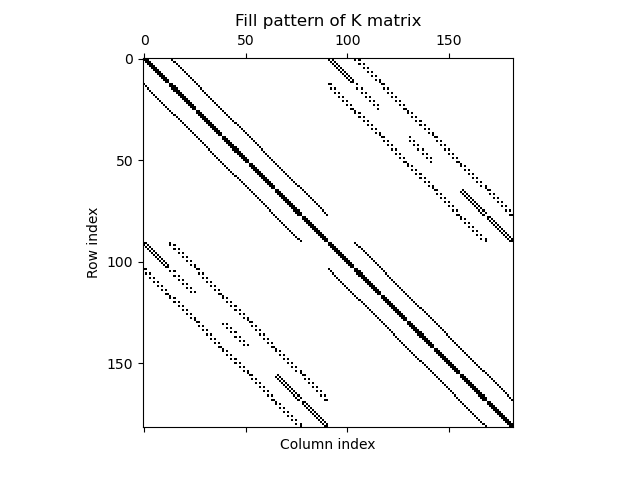

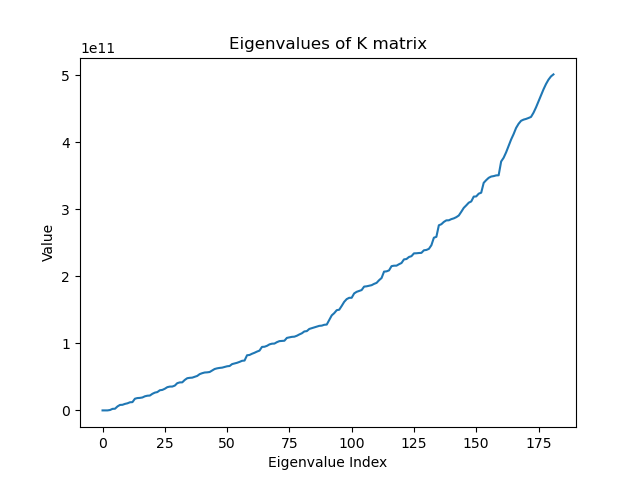

In [150]:
fig = plt.figure()
ax = plt.subplot(111)
plt.spy(K);
ax.set_title('Fill pattern of K matrix');
ax.set_ylabel('Row index');
ax.set_xlabel('Column index');
plt.show()

fig = plt.figure()
ax = plt.subplot(111)
d, _ = np.linalg.eig(K)
plt.plot(np.sort( d ) );
ax.set_title('Eigenvalues of K matrix');
ax.set_xlabel('Eigenvalue Index')
ax.set_ylabel('Value');
plt.show()

Create an  external nodal force vector with a prescribed load at the right hand side of the bar.

In [151]:
load = -10e7
f = np.zeros((2*N,),dtype=np.float64)
indices = np.array(np.where(V[:,0]>2.9),dtype=np.int).flatten() + N
f[ indices ] =  load

/var/folders/76/m4ks_3rs08bb4jc5gt400t640000gp/T/ipykernel_31329/2751714476.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = np.array(np.where(V[:,0]>2.9),dtype=np.int).flatten() + N


Apply Direchlet boundary conditions to displacement field for the left vertices.

In [152]:
xindices = np.array(np.where( V[:,0] < -2.9), dtype=int).flatten()
yindices = xindices + N

indices = np.hstack((xindices, yindices))
values  = np.zeros(indices.shape,dtype=np.float64)

F = np.setdiff1d(np.arange(2*N), indices)

for i in range(len(indices)):
    index = indices[i]
    value = values[i]  
    f[index] = values[i]
    K[xindices, :] = 0.0
    K[:,yindices] = 0.0
    K[xindices, yindices] = 1.0
    for j in range(len(f)):
        if (j != 0) and (j != len(f) - 1):
            f[j] -= value * K[j, index]

    # TODO - add boundary conditions here

After having applied the boundary conditions we can now solve for the displacement field

In [153]:
u = np.zeros(f.shape, dtype=np.float64)
u[indices] = values
KFF = K[F,:][:,F]
fF  = f[F]
u[F] = np.linalg.solve(KFF, fF)

From displacements we can compute the spatial deformed coordinates and visualize the deformed mesh.

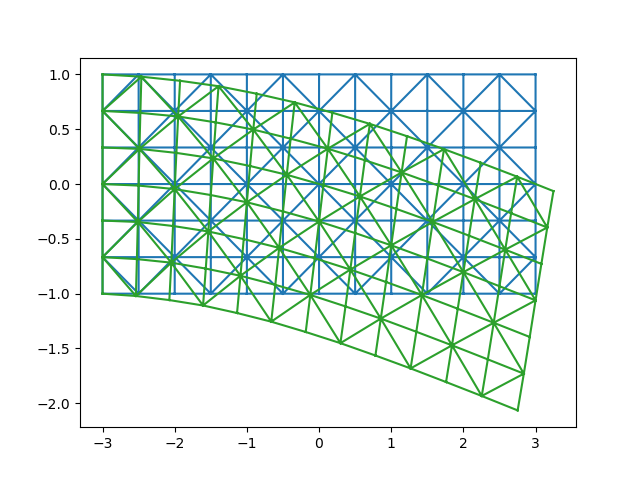

Undeformed beam area:  12.0
Deformed beam area:  12.411255904156214


In [154]:
x = V[:,0] + u[0:N]
y = V[:,1] + u[N:2*N]

fig = plt.figure()
plt.triplot(V[:,0],V[:,1],T)
plt.triplot(x,y,T)
plt.show()

A0 = compute_triangle_areas(V,T)
A = compute_triangle_areas(np.vstack((x,y)).T,T)
print("Undeformed beam area: ", np.sum(A0))
print("Deformed beam area: ", np.sum(A))

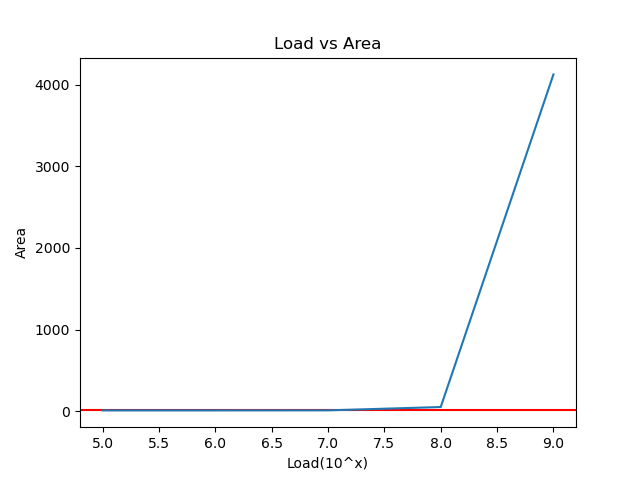

In [158]:
loadlist = [10e5, 10e6, 10e7, 10e8, 10e9]
area = []
for i in range(len(loadlist)):
    load = loadlist[i]
    f = np.zeros((2*N,),dtype=np.float64)
    indices = np.array(np.where(V[:,0]>2.9),dtype=int).flatten() + N
    f[ indices ] =  load
    xindices = np.array(np.where( V[:,0] < -2.9), dtype=int).flatten()
    yindices = xindices + N

    indices = np.hstack((xindices, yindices))
    values  = np.zeros(indices.shape,dtype=np.float64)

    F = np.setdiff1d(np.arange(2*N), indices)

    for i in range(len(indices)):
        index = indices[i]
        value = values[i]  
        f[index] = values[i]
        K[xindices, :] = 0.0
        K[:,yindices] = 0.0
        K[xindices, yindices] = 1.0
        for j in range(len(f)):
            if (j != 0) and (j != len(f) - 1):
                f[j] -= value * K[j, index]

        # TODO - add boundary conditions here
    u = np.zeros(f.shape, dtype=np.float64)
    u[indices] = values
    KFF = K[F,:][:,F]
    fF  = f[F]
    u[F] = np.linalg.solve(KFF, fF)
    x = V[:,0] + u[0:N]
    y = V[:,1] + u[N:2*N]
    A = compute_triangle_areas(np.vstack((x,y)).T,T)
    area.append(np.sum(A))

xaxis = np.array([5, 6, 7, 8, 9])
fig = plt.figure()
plt.axhline(y=12, color='r', linestyle='-')
plt.plot(xaxis, area)
plt.title('Load vs Area')
plt.xlabel('Load(10^x)')
plt.ylabel('Area')
plt.show()


That is all folks